# import

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
import re
import spacy
from spacy.tokenizer import Tokenizer


import tensorflow
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Embedding, Input, GRU, Bidirectional, GlobalMaxPooling1D,GlobalAveragePooling1D, Dropout,SpatialDropout1D,Conv1D,concatenate,Flatten, SimpleRNN, LSTM
#Bidirectional은 양방향으로 데이터를 보기 위해서 사용되는 함수
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing import sequence
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.models import load_model

/home/q1cho/.conda/envs/q1/lib/python3.7/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# !python -m spacy download en_core_web_sm

In [3]:
# !spacy download en_core_web_sm

-- 데이터 불러오기

In [4]:
# loading the dataset
df = pd.read_csv('/home/q1cho/ViT/IMDB Dataset.csv')
df.head()

,review,sentiment
0,One of the other reviewers has mentioned that ...,positive
1,A wonderful little production. <br /><br />The...,positive
2,I thought this was a wonderful way to spend ti...,positive
3,Basically there's a family where a little boy ...,negative
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive


#EDA + PreProcess

In [5]:
cutoff = int(len(df)*0.7)

train_data = df[:cutoff]
test_data = df[cutoff:]

In [6]:
print(len(train_data))
print(len(test_data))

35000
15000


# stopwords

In [7]:
nlp = spacy.load('en_core_web_sm')

In [8]:
# loading stop words
stop_words = nlp.Defaults.stop_words
# removing 'not' word from stop words list because this word has enough effect on sentiment
nlp.Defaults.stop_words.remove('not')
nlp.vocab['not'].is_stop = False

In [18]:
# creating a function to preprocess all text
def preprocess(sentence):
    # making all words in lower case
    sentence = sentence.lower()
    # removing HTML tag
    sentence = sentence.replace('<br /><br />', ' ')
    # removing URL
    sentence = sentence.replace('https://', ' ')
    # removing all characters other than alphabets
    sentence = re.sub('[^a-zA-Z]',' ',sentence)

    sentence = " ".join(sentence.split())
    
    # remove stop words
    raw = []
    for word in sentence.split():
        if word in stop_words:
            pass
        else:
            raw.append(word)
    sentence = ' '.join(raw)
    # lemmatization
    sentence = ' '.join([i.lemma_ for i in nlp(sentence)])

    
    return sentence

In [19]:
X_train_raw = train_data['review'].map(lambda com : preprocess(com))
X_test_raw = test_data['review'].map(lambda com : preprocess(com))

Y_train = train_data['sentiment']

In [20]:
print("X train shape : ", X_train_raw.shape)
print("X test shape : ", X_test_raw.shape)
print("y train shape : ", Y_train.shape)

X train shape :  (35000,)
X test shape :  (15000,)
y train shape :  (35000,)


In [21]:
X_train_raw

0        reviewer mention watch oz episode ll hook righ...
1        wonderful little production filming technique ...
2        think wonderful way spend time hot summer week...
3        basically s family little boy jake think s zom...
4        petter mattei s love time money visually stunn...
                               ...                        
34995    awful awful awful real world issue deal blatan...
34996    like action movie softspot b flick bad dialogu...
34997    begin nice note falter quickly let expectation...
34998    aardman pixar aardman animation prove animatio...
34999    movie laugh bloody joke tell truth unbelievabl...
Name: review, Length: 35000, dtype: object

In [22]:
max_features=90000 #단어 갯수(8만5천개)
maxlen=90 # 단어개수 중간값 87이여서 반올림하여 90
embed_size=300 #embeding matrix크기가 300


tok=Tokenizer(num_words=max_features,lower=True)
tok.fit_on_texts(X_train_raw)
tok.fit_on_texts(X_test_raw)
X_train = sequence.pad_sequences(tok.texts_to_sequences(X_train_raw),
                        maxlen = maxlen, truncating = "pre")
X_test = sequence.pad_sequences(tok.texts_to_sequences(X_test_raw),
                       maxlen = maxlen, truncating = "pre")

In [23]:
X_train[:3]

array([[27034,  8260, 35642, 12003,  4932,   760,  1992, 16596,   169,
         1932,  5844,  7538,  6864,  6618,   104,   118,   146,   700,
           79,    24,    52,   409,     4,  1359,   359,    81,   208,
         1110,  2033,   126,   359,   944,   359,   615,  2526,    55,
            4,   610,   133,    13,   949,  1249,  1815,   266,     4,
         1274,    10,   543,   831,  2526,    38, 14169,   130,   364,
         1116,   399,     5,   399,  5206,  3260,  1540,   110,   801,
        16597,  4322,   110,    83,   374,   118,  6990,   469,   454,
         4322,    76,   899,  3963,   228,   494,  1054,   899,   272,
           10,  2526,  3105,  2713,  2926,  1286,     1,   400,   271],
       [    0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,   255,    40,   193,  8078,  1421, 16598,    47,     8,
         1746,  1107,    43,  3135, 31838,   138,  1486,   296,   194,
           36,   398,   596,   331,  3359,     5,    38, 52143,   293,
     

In [24]:
tok.word_index

{'s': 1,
 'movie': 2,
 'film': 3,
 't': 4,
 'not': 5,
 'like': 6,
 'good': 7,
 'time': 8,
 'character': 9,
 'watch': 10,
 'bad': 11,
 'story': 12,
 'see': 13,
 'think': 14,
 'scene': 15,
 'great': 16,
 'look': 17,
 'know': 18,
 'people': 19,
 'end': 20,
 'don': 21,
 'way': 22,
 'love': 23,
 'go': 24,
 'thing': 25,
 'play': 26,
 'come': 27,
 'find': 28,
 'man': 29,
 'act': 30,
 'well': 31,
 'life': 32,
 'plot': 33,
 'make': 34,
 'work': 35,
 'actor': 36,
 'year': 37,
 'get': 38,
 'want': 39,
 'little': 40,
 'try': 41,
 'feel': 42,
 'give': 43,
 'm': 44,
 've': 45,
 'take': 46,
 'old': 47,
 'director': 48,
 'lot': 49,
 'real': 50,
 'guy': 51,
 'show': 52,
 'funny': 53,
 'performance': 54,
 'doesn': 55,
 'woman': 56,
 'didn': 57,
 'big': 58,
 'actually': 59,
 'say': 60,
 'cast': 61,
 'role': 62,
 'star': 63,
 'tell': 64,
 'new': 65,
 'leave': 66,
 'young': 67,
 'long': 68,
 'point': 69,
 'start': 70,
 'day': 71,
 'world': 72,
 'girl': 73,
 'horror': 74,
 'set': 75,
 'turn': 76,
 'write': 

In [25]:
word_index = tok.word_index

In [26]:
word_index = {e:i for e,i in word_index.items() if i <= max_features}

In [27]:
x_train, x_val, y_train, y_val = train_test_split(X_train,Y_train,train_size=0.9, random_state=199)
print(x_train.shape," ",y_train.shape," ",x_val.shape," ",y_val.shape)

(31500, 90)   (31500,)   (3500, 90)   (3500,)


# Word2vec

In [28]:
import gensim
from gensim.models import KeyedVectors

In [29]:
word2vec_model = KeyedVectors.load_word2vec_format('/home/q1cho/ViT/GoogleNews-vectors-negative300.bin.gz', binary=True)


In [30]:
print('모델의 크기(shape) :',word2vec_model.vectors.shape) # 모델의 크기 확인

모델의 크기(shape) : (3000000, 300)


In [31]:
embedding_matrix = np.zeros((max_features, 300))
print('임베딩 행렬의 크기(shape) :',np.shape(embedding_matrix))

임베딩 행렬의 크기(shape) : (90000, 300)


In [32]:
def get_vector(word):
    if word in word2vec_model:
        return word2vec_model[word]
    else:
        return None

In [33]:
for word, index in word_index.items():
    # 단어와 맵핑되는 사전 훈련된 임베딩 벡터값
    vector_value = get_vector(word)
    if vector_value is not None:
        embedding_matrix[index-1] = vector_value

# 모델구성하기

In [49]:
input = Input(shape=(maxlen, )) 
layer = Embedding(max_features, 300, weights=[embedding_matrix], input_length=maxlen, trainable=True)(input)
layer = LSTM(128)(layer)
layer = Dense(50,activation='relu')(layer)
layer = Flatten()(layer)
layer= Dense(2, activation="softmax")(layer) #softmax로 사용

In [50]:
model = Model(inputs = input, outputs = layer)  

In [51]:
model.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 90)]              0         
                                                                 
 embedding_2 (Embedding)     (None, 90, 300)           27000000  
                                                                 
 lstm_2 (LSTM)               (None, 128)               219648    
                                                                 
 dense_2 (Dense)             (None, 50)                6450      
                                                                 
 flatten_1 (Flatten)         (None, 50)                0         
                                                                 
 dense_3 (Dense)             (None, 2)                 102       
                                                                 
Total params: 27,226,200
Trainable params: 27,226,200
Non-t

In [52]:
model.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])

In [53]:
file_path = '{epoch:02d}-{val_loss:.5f}.h5'
checkpoint = ModelCheckpoint(file_path,monitor='val_loss',verbose = 1, save_best_only=True)
early_stop = EarlyStopping(monitor='val_loss',patience=1)

In [54]:
y_train[y_train=='positive'] = 1
y_train[y_train=='negative'] = 0
y_val[y_val=='positive'] = 1
y_val[y_val=='negative'] = 0

In [55]:
from tensorflow.keras.utils import to_categorical 
y_train_one = to_categorical(y_train)
y_val_one = to_categorical(y_val)

In [56]:
hist = model.fit(x_train, y_train_one, epochs=3,batch_size=256, validation_data=(x_val,y_val_one), callbacks= [checkpoint,early_stop])

Epoch 1/3
124/124 [==============================] - ETA: 0s - loss: 0.4411 - accuracy: 0.7832
Epoch 1: val_loss improved from inf to 0.33502, saving model to 01-0.33502.h5
124/124 [==============================] - 67s 532ms/step - loss: 0.4411 - accuracy: 0.7832 - val_loss: 0.3350 - val_accuracy: 0.8669
Epoch 2/3
124/124 [==============================] - ETA: 0s - loss: 0.2161 - accuracy: 0.9179
Epoch 2: val_loss did not improve from 0.33502
124/124 [==============================] - 62s 504ms/step - loss: 0.2161 - accuracy: 0.9179 - val_loss: 0.3969 - val_accuracy: 0.8537


In [58]:
import matplotlib.pyplot as plt
def acc_loss_plot(hist):
    fig, loss_ax = plt.subplots()
    acc_ax = loss_ax.twinx()

    loss_ax.plot(hist.history['loss'], 'y', label='train loss')
    loss_ax.plot(hist.history['val_loss'], 'r', label='val loss')
    loss_ax.set_xlabel('epoch')
    loss_ax.set_ylabel('loss')
    loss_ax.legend(loc = 'upper left')

    acc_ax.plot(hist.history['accuracy'], 'b', label='train acc')
    acc_ax.plot(hist.history['val_accuracy'], 'g', label='val acc')
    acc_ax.set_ylabel('accuracy')
    acc_ax.legend(loc='upper right')
    # s= plt.show()
    plt.show()

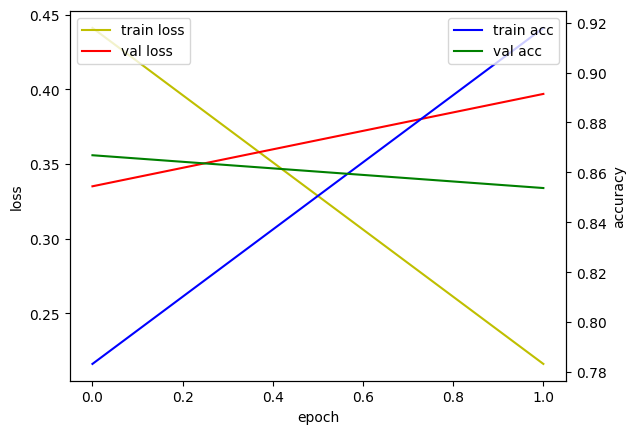

In [59]:
acc_loss_plot(hist)

In [60]:
y_test = test_data['sentiment'] 
y_test[y_test=='positive'] = 1
y_test[y_test=='negative'] = 0
y_test_one = to_categorical(y_test)

In [61]:
y_test_one

array([[1., 0.],
       [0., 1.],
       [1., 0.],
       ...,
       [1., 0.],
       [1., 0.],
       [1., 0.]], dtype=float32)

In [62]:
score = model.evaluate(X_test,y_test_one)

469/469 [==============================] - 16s 33ms/step - loss: 0.3720 - accuracy: 0.8599


In [63]:
score[1]

0.8598666787147522

-- 양방향

In [81]:
import tensorflow as tf
from tensorflow.keras.layers import Dense, LSTM, Embedding, Bidirectional
from keras.models import Sequential

model = Sequential()
input = Input(shape=(maxlen, ))
model.add(Embedding(max_features, 300, weights=[embedding_matrix], input_length=maxlen, trainable=True))
model.add(Bidirectional(LSTM(128)))
model.add(Dense(50, activation='relu'))
model.add(Flatten())
model.add(Dense(2, activation='softmax'))

model.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])

In [82]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_18 (Embedding)    (None, 90, 300)           27000000  
                                                                 
 bidirectional_2 (Bidirectio  (None, 256)              439296    
 nal)                                                            
                                                                 
 dense_5 (Dense)             (None, 50)                12850     
                                                                 
 flatten_2 (Flatten)         (None, 50)                0         
                                                                 
 dense_6 (Dense)             (None, 2)                 102       
                                                                 
Total params: 27,452,248
Trainable params: 27,452,248
Non-trainable params: 0
__________________________________________

In [84]:
file_path = '{epoch:02d}-{val_loss:.5f}.h5'
checkpoint = ModelCheckpoint(file_path,monitor='val_loss',verbose = 1, save_best_only=True)
early_stop = EarlyStopping(monitor='val_loss',patience=1)

In [85]:
y_train[y_train=='positive'] = 1
y_train[y_train=='negative'] = 0
y_val[y_val=='positive'] = 1
y_val[y_val=='negative'] = 0

In [86]:
from tensorflow.keras.utils import to_categorical 
y_train_one = to_categorical(y_train)
y_val_one = to_categorical(y_val)

In [87]:
hist = model.fit(x_train, y_train_one, epochs=3,batch_size=256, validation_data=(x_val,y_val_one), callbacks= [checkpoint,early_stop])

Epoch 1/3
124/124 [==============================] - ETA: 0s - loss: 0.4461 - accuracy: 0.7738
Epoch 1: val_loss improved from inf to 0.35725, saving model to 01-0.35725.h5
124/124 [==============================] - 97s 767ms/step - loss: 0.4461 - accuracy: 0.7738 - val_loss: 0.3572 - val_accuracy: 0.8451
Epoch 2/3
124/124 [==============================] - ETA: 0s - loss: 0.2145 - accuracy: 0.9179
Epoch 2: val_loss did not improve from 0.35725
124/124 [==============================] - 89s 719ms/step - loss: 0.2145 - accuracy: 0.9179 - val_loss: 0.3583 - val_accuracy: 0.8523


In [88]:
y_test = test_data['sentiment'] 
y_test[y_test=='positive'] = 1
y_test[y_test=='negative'] = 0
y_test_one = to_categorical(y_test)

/home/q1cho/.conda/envs/q1/lib/python3.7/site-packages/pandas/core/generic.py:8870: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return self._update_inplace(result)


In [89]:
score = model.evaluate(X_test,y_test_one)
score[1]

469/469 [==============================] - 27s 58ms/step - loss: 0.3368 - accuracy: 0.8600


0.8600000143051147